In [1]:
#-----------------------------------------
# Title: Regularization Regression With Abalone Dataset
# Subtitle: DDS-8555, Assignment 3, Part 1
# Author: Madgene Moise
# Date: Sunday, June 1, 2025
#-----------------------------------------

In [2]:
# Step 1: Import necessary library
import pandas as pd

In [3]:
# Load the training and testing datasets
train_df = pd.read_csv("/kaggle/input/playground-series-s4e4/train.csv") 
test_df = pd.read_csv("/kaggle/input/playground-series-s4e4/test.csv")

# Display the first few rows of the training dataset
train_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [4]:
# Categorical: Sex (Male=M, Female=F, Infant=I)
# Numerical: Length, Diameter, Height, Whole weight, Whole weight.1, Whole weight.2, Shell weight.
# Target : Rings (This is the response variable we aim to predict)

# Preprocessing: Convert categorical Sex to dummy variables.
# Check for multicolinearity or duplicate features (Whole weight seems repeated).

# (1) Encode the categorical variable sex.
# (2) Build a regularized regression model (using Lasso) to perform feature selection.
# (3) Interpret the model and check regression assumptions

# Preprocessing and fitting a Laso regression model

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [5]:
# Define features and target
X = train_df.drop(columns=["id", "Rings"])
y = train_df["Rings"]

In [6]:
# Identify categorical and numerical columns
categorical_features = ["Sex"]
numerical_features = [col for col in X.columns if col not in categorical_features]

In [7]:
# Define the preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(drop='first'), categorical_features)
])

In [8]:
# Define the LassoCV regression pipeline
lasso_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LassoCV(cv=5, random_state=42))
])

In [9]:
# Fit the model
lasso_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Length', 'Diameter',
                                                   'Height', 'Whole weight',
                                                   'Whole weight.1',
                                                   'Whole weight.2',
                                                   'Shell weight']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Sex'])])),
                ('regressor', LassoCV(cv=5, random_state=42))])

In [10]:
# Retrieve coefficients and feature names
feature_names = (
    numerical_features + 
    list(lasso_pipeline.named_steps["preprocessor"].named_transformers_["cat"].get_feature_names_out(["Sex"]))
)
coefficients = lasso_pipeline.named_steps["regressor"].coef_

In [11]:
# Combine into a DataFrame
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", key=abs, ascending=False)

print (coef_df)

          Feature  Coefficient
4  Whole weight.1    -3.155410
6    Shell weight     2.747700
3    Whole weight     1.528500
2          Height     0.797716
7           Sex_I    -0.698571
5  Whole weight.2    -0.625385
1        Diameter     0.589235
0          Length    -0.037121
8           Sex_M    -0.000000


The Lasso regression model has selected and assigned non-zero coefficients to a subset of features. 
Top Positive Predictors:
* Shell weight and Whole weight suggest heavier specimens tend to have more rings, which aligns with the idea that older abalones are larger and heavier.
* Height is also positively associated with ring count.

Top Negative Predictors:
* Whole weight.1: This component of weight negatively correlates with ring count, possibly reflecting a distribution of mass in younger abalones.
* Sex_I (Infants): Being classified as an infant is associated with fewer rings (younger age), as expected.

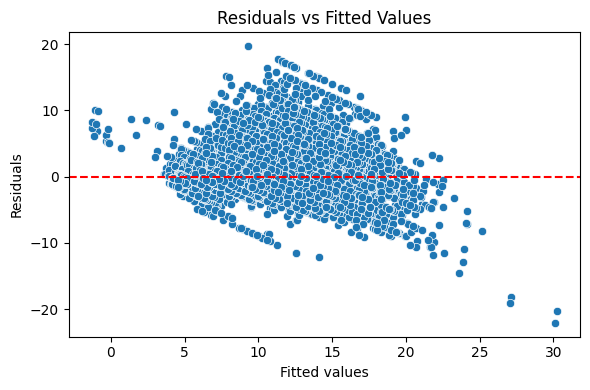

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


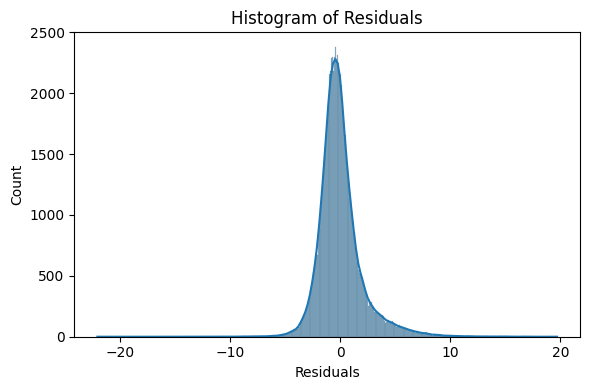

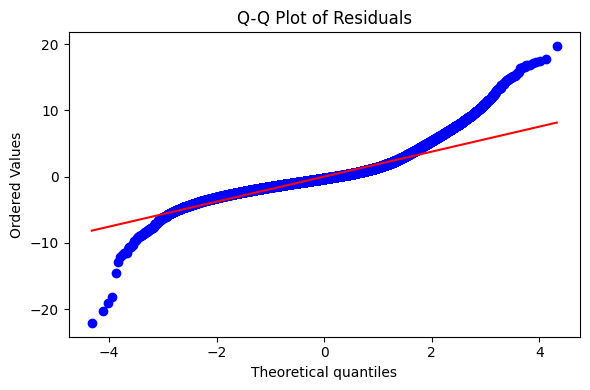

In [12]:
# Check regression assumptions (normality, homoscedasticity, outliers).
# Visualize residuals to validate the model.

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error

# Predict on training data
y_pred = lasso_pipeline.predict(X)
residuals = y - y_pred

# Plot residuals vs fitted values
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.tight_layout()
plt.show()

# Q-Q plot for residuals
from scipy import stats
plt.figure(figsize=(6, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

For the plot of Residuals vs. Fitted Values, the residuals appear fairly evenly scattered around zero, which suggests the assumption of linearity and no major heteroscedasticity (non-constant variance) is reasonably met. However, slight funneling toward higher fitted values may suggest mild heteroscedasticity. 

For the plot of Histogram of Residuals, the residuals show a somewhat bell-shaped distribution but exhibit moderate skewness. This indicates mild deviation from normality, which is not uncommon in real-world data. 

For the Quantile(Q)-Quantile(Q) plot, most points lie along the diagonal reference line, indicating approximate normality. Some deviations at the tails suggest possible outliers or slight non-normality.

It looks like Lasso effectively selected a few influential features, simplifying the model while retaining predictive power. The important predictors (Shell weight, Whole weight, and Height) are positively associated with ring count. Also, being an Infant and having a higher Whole weight.1 are negatively associated. 

The overall assumption is that the residuals are approximately normal, and the variance appears to be mostly constant.

In [13]:
# Prepare test set features (excluding 'id')
X_test = test_df.drop(columns=["id"])

# Generate predictions
test_predictions = lasso_pipeline.predict(X_test)
test_predictions_clipped = test_predictions.clip(min=0)

# Prepare submission DataFrame
submission_df = pd.DataFrame({
    "id": test_df["id"],
    "Rings": test_predictions_clipped
})

submission_df.head()

,id,Rings
0,90615,8.662825
1,90616,10.045565
2,90617,10.346088
3,90618,10.855420
4,90619,7.762872
